# **Installisions**

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

# **Imports**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# **Load Data After Preprocessing**

In [3]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=bc96754d-9be4-4da4-9709-8a1d51da1efd
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:03<00:00, 231MB/s] 


'sepsis_data.csv'

# **Loads a patient-level time series dataset, drops unused columns, imputes missing values if find tiny values, and prints class distribution.**

In [4]:
def load_and_preprocess_data(filepath):
    try:
        dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns 
                     if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
        dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
        
        df = pd.read_csv(filepath, dtype=dtype_dict)
        df = df.sort_values(['Patient_ID', 'ICULOS'])
        
        cols_to_drop = ['Unit2_observed', 'Unit1_observed', 'HospAdmTime','Age']
        existing_cols = [col for col in cols_to_drop if col in df.columns]
        if existing_cols:
            df = df.drop(columns=existing_cols)
            print(f"Dropped columns: {existing_cols}")
        else:
            print("None of the specified columns exist in the DataFrame")
        
        cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
        
        df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
        df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
        df[cols_to_impute] = df[cols_to_impute].fillna(0)
        
        print("Initial class distribution:")
        print(df['SepsisLabel'].value_counts())
        return df
    except Exception as e:
        print(f"Error in load_and_preprocess_data: {e}")
        raise
df = load_and_preprocess_data("/kaggle/working/sepsis_data.csv")

Dropped columns: ['Unit2_observed', 'Unit1_observed', 'HospAdmTime', 'Age']
Initial class distribution:
SepsisLabel
0    1510640
1      26715
Name: count, dtype: int64


# **Creates sequences from patient data, ensuring each sequence contains time steps for model training, while handling missing data and ensuring balanced labels.**

In [5]:
def create_patient_sequences(df, sequence_length=10):
    try:
        sequences = []
        labels = []
        
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
        
        for pid, group in df.groupby('Patient_ID'):
            features = group[feature_cols].values
            sepsis_labels = group['SepsisLabel'].values
            
            if len(features) < sequence_length:
                pad_len = sequence_length - len(features)
                features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
                sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
            
            for i in range(0, len(features) - sequence_length + 1, 1):
                seq = features[i:i+sequence_length]
                label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
                sequences.append(seq)
                labels.append(label)
        
        X = np.array(sequences, dtype=np.float32)
        y = np.array(labels, dtype=np.int8)
        
        print(f"Created {len(X)} sequences")
        print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
        return X, y, feature_cols
    except Exception as e:
        print(f"Error in create_patient_sequences: {e}")
        raise
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)

Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


# **Performs decision tree-based undersampling of the majority class to a target sample size using feature importance.**

In [6]:
def decision_tree_undersampling(X, y, target_samples=35000):
    try:
        print(f"\nUndersampling majority class to {target_samples} samples...")
        
        majority_indices = np.where(y == 0)[0]
        
        if len(majority_indices) <= target_samples:
            return X, y
        
        np.random.shuffle(majority_indices)
        subset_indices = majority_indices[:min(50000, len(majority_indices))]
        
        X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y[subset_indices], X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        sample_importances = dt.feature_importances_.sum()
        selected_indices = np.random.choice(subset_indices, size=target_samples, replace=False)
        
        minority_indices = np.where(y == 1)[0]
        final_indices = np.concatenate([selected_indices, minority_indices])
        
        return X[final_indices], y[final_indices]
    except Exception as e:
        print(f"Error in decision_tree_undersampling: {e}")
        raise


# **performs upsampling on the minority class by generating synthetic samples using decision tree-guided noise.**

In [7]:
def decision_tree_upsampling(X, y, target_samples=27000):
    try:
        print(f"\nUpsampling minority class to {target_samples} samples...")
        
        minority_indices = np.where(y == 1)[0]
        
        if len(minority_indices) >= target_samples:
            return X, y
        
        num_to_generate = target_samples - len(minority_indices)
        
        X_flattened = X.reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y, X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        synthetic_samples = []
        for _ in range(num_to_generate):
            base_sample = X[np.random.choice(minority_indices)]
            
            synthetic_sample = base_sample.copy()
            for t in range(X.shape[1]):
                for f in range(X.shape[2]):
                    if dt.feature_importances_[f] > 0.01:
                        noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                        synthetic_sample[t, f] += noise
            
            synthetic_samples.append(synthetic_sample)
        
        synthetic_samples = np.array(synthetic_samples)
        
        X_upsampled = np.concatenate([X, synthetic_samples])
        y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
        
        return X_upsampled, y_upsampled
    except Exception as e:
        print(f"Error in decision_tree_upsampling: {e}")
        raise


# **prepares a balanced dataset by performing both undersampling of the majority class and upsampling of the minority class, then shuffling the resulting data..**

In [8]:
def prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000):
    try:
        print("\nPreparing balanced dataset...")
        
        X_undersampled, y_undersampled = decision_tree_undersampling(X, y, target_samples=target_class0)
        X_balanced, y_balanced = decision_tree_upsampling(X_undersampled, y_undersampled, target_samples=target_class1)
        
        indices = np.arange(len(y_balanced))
        np.random.shuffle(indices)
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
        
        print(f"Final balanced dataset - Class 0: {np.sum(y_balanced == 0)}, Class 1: {np.sum(y_balanced == 1)}")
        return X_balanced, y_balanced
    except Exception as e:
        print(f"Error in prepare_balanced_dataset: {e}")
        raise
X_balanced, y_balanced = prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000)


Preparing balanced dataset...

Undersampling majority class to 35000 samples...

Upsampling minority class to 27000 samples...
Final balanced dataset - Class 0: 35000, Class 1: 27000


# **performs a custom train-test split, ensuring balanced classes in both the training and testing sets by limiting the number of samples for each class**

In [9]:
def custom_train_test_split_with_balancing(X, y, train_class0=35000, train_class1=27000):
    try:
        print("\nCustom train-test split with balanced classes...")
        
        indices_class0 = np.where(y == 0)[0]
        indices_class1 = np.where(y == 1)[0]
        
        print(f"Total samples - Class 0: {len(indices_class0)}, Class 1: {len(indices_class1)}")
        
        train_class0 = min(train_class0, len(indices_class0))
        train_class1 = min(train_class1, len(indices_class1))
        
        np.random.shuffle(indices_class0)
        np.random.shuffle(indices_class1)
        
        train_indices_class0 = indices_class0[:train_class0]
        train_indices_class1 = indices_class1[:train_class1]
        
        test_indices_class0 = indices_class0[train_class0:]
        test_indices_class1 = indices_class1[train_class1:]
        
        train_indices = np.concatenate([train_indices_class0, train_indices_class1])
        test_indices = np.concatenate([test_indices_class0, test_indices_class1])
        
        np.random.shuffle(train_indices)
        
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
        print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")
        
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Error in custom_train_test_split_with_balancing: {e}")
        raise
        
X_train, X_test, y_train, y_test = custom_train_test_split_with_balancing(X_balanced, y_balanced, train_class0=28000, train_class1=21600)



Custom train-test split with balanced classes...
Total samples - Class 0: 35000, Class 1: 27000
Training set - Class 0: 28000, Class 1: 21600
Test set - Class 0: 7000, Class 1: 5400


# **builds a simplified ResNet model for time-series data, focusing on fewer neurons, one residual block, and a global average pooling layer for the output.**

In [21]:
def build_resnet_model(input_shape):
    try:
        inputs = Input(shape=input_shape)
        
        x = Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # Single Residual Block
        shortcut = x
        x = Conv1D(128, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
        return model
    except Exception as e:
        print(f"Error in build_resnet_model: {e}")
        raise


# **calculates a custom utility score based on classification outcomes using weights for true positives (tp), false positives (fp), true negatives (tn), and false negatives (fn). It also calculates the utility percentage relative to the maximum achievable score.**

In [22]:
def calculate_utility_score(y_true, y_pred, tp_weight=10, fp_weight=-2, tn_weight=1, fn_weight=-5):
    try:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        utility_score = (tp * tp_weight) + (fp * fp_weight) + (tn * tn_weight) + (fn * fn_weight)
        max_score = (np.sum(y_true == 1) * tp_weight) + (np.sum(y_true == 0) * tn_weight)
        utility_percentage = (utility_score / max_score) * 100 if max_score > 0 else 0
        
        return utility_score, utility_percentage
    except Exception as e:
        print(f"Error in calculate_utility_score: {e}")
        raise

In [23]:

# Build and train model
model = build_resnet_model(input_shape=(X_train.shape[1], X_train.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6744 - auc: 0.7252 - loss: 0.6124 - val_accuracy: 0.7203 - val_auc: 0.7980 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 2/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7197 - auc: 0.7881 - loss: 0.5503 - val_accuracy: 0.7317 - val_auc: 0.8105 - val_loss: 0.5309 - learning_rate: 0.0010
Epoch 3/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7342 - auc: 0.8069 - loss: 0.5299 - val_accuracy: 0.7443 - val_auc: 0.8216 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 4/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7448 - auc: 0.8196 - loss: 0.5149 - val_accuracy: 0.7429 - val_auc: 0.8275 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 5/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7573 - auc: 0.8343 - loss: 0.4971 - val_accuracy: 0.7542 - val_auc: 0.8383 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 6/30
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7660 - auc: 0.

# **Evaluates the model's performance**

In [26]:
def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate the model and display metrics."""
    try:
        print(f"\n{set_name} Set Evaluation:")
        
        y_prob = model.predict(X, batch_size=64, verbose=0)
        y_pred = (y_prob > 0.5).astype(int).flatten()
        
        print(classification_report(y, y_pred))
        
        auc = roc_auc_score(y, y_prob)
        print(f"ROC AUC: {auc:.4f}")
        
        utility_score, utility_percentage = calculate_utility_score(y, y_pred)
        print(f"Utility Score: {utility_score}")
        print(f"Utility Score Percentage: {utility_percentage:.2f}%")
        
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Sepsis', 'Sepsis'],
                   yticklabels=['No Sepsis', 'Sepsis'])
        plt.title(f'Confusion Matrix - {set_name} Set')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise

# **Evaluate model on training set and display confusion matrix & classification report**


Training Set Evaluation:


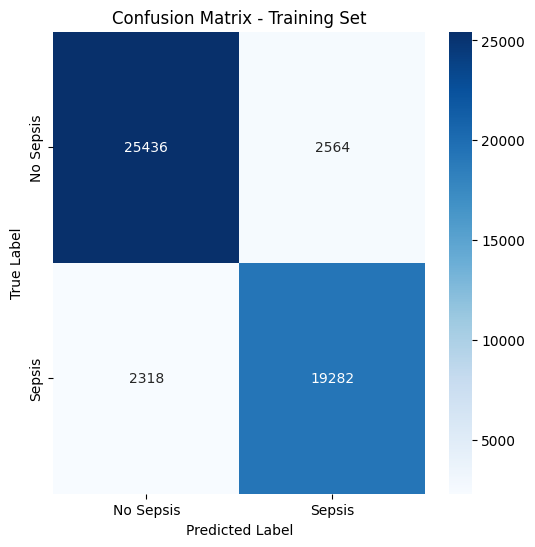

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     28000
           1       0.88      0.89      0.89     21600

    accuracy                           0.90     49600
   macro avg       0.90      0.90      0.90     49600
weighted avg       0.90      0.90      0.90     49600



In [27]:
print("\nTraining Set Evaluation:")
y_train_pred_prob = model.predict(X_train, batch_size=64, verbose=0)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.title('Confusion Matrix - Training Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_train, y_train_pred))

# **Evaluate AUC and Utility Score for training set**

In [28]:
from sklearn.metrics import roc_auc_score
y_train_pred_prob = model.predict(X_train, batch_size=64, verbose=0)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

train_auc = roc_auc_score(y_train, y_train_pred_prob)
print(f"Training Set ROC AUC: {train_auc:.4f}")

train_utility_score, train_utility_percentage = calculate_utility_score(y_train, y_train_pred)
print(f"Training Set Utility Score: {train_utility_score}")
print(f"Training Set Utility Score Percentage: {train_utility_percentage:.2f}%")

Training Set ROC AUC: 0.9632
Training Set Utility Score: 201538
Training Set Utility Score Percentage: 82.60%


# **Model Loss and AUC**

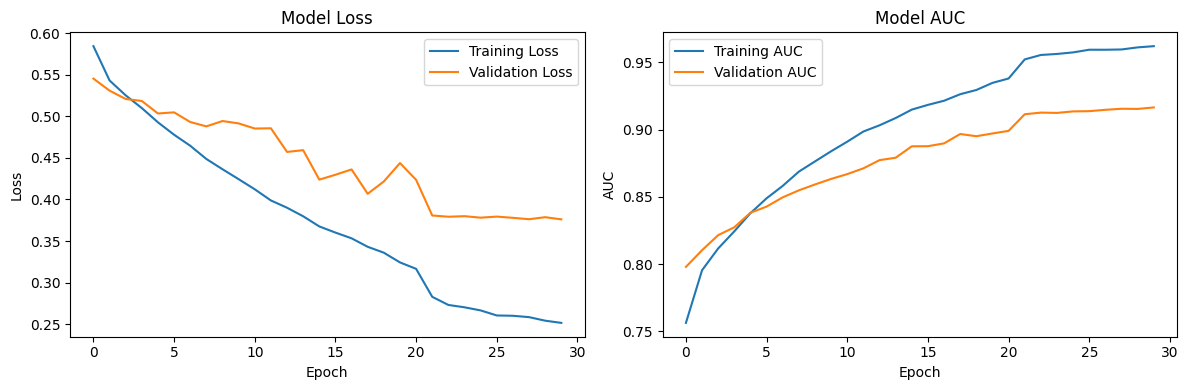

In [29]:
# Plot training history (Loss and AUC)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# **Test Set Confusion Matrix and Classification Report**


Test Set Evaluation:


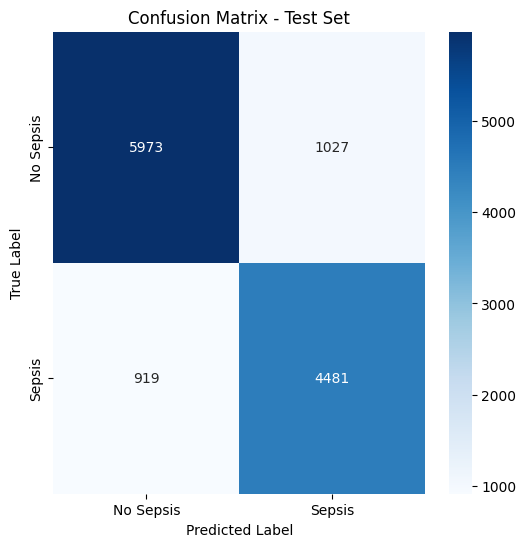

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7000
           1       0.81      0.83      0.82      5400

    accuracy                           0.84     12400
   macro avg       0.84      0.84      0.84     12400
weighted avg       0.84      0.84      0.84     12400



In [30]:
print("\nTest Set Evaluation:")
y_test_pred_prob = model.predict(X_test, batch_size=64, verbose=0)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_test, y_test_pred))


# **Evaluate AUC and Utility Score for test set**

In [31]:
y_test_pred_prob = model.predict(X_test, batch_size=64, verbose=0)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# ROC AUC for test set
test_auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"Test Set ROC AUC: {test_auc:.4f}")

# Utility Score
test_utility_score, test_utility_percentage = calculate_utility_score(y_test, y_test_pred)
print(f"Test Set Utility Score: {test_utility_score}")
print(f"Test Set Utility Score Percentage: {test_utility_percentage:.2f}%")


Test Set ROC AUC: 0.9154
Test Set Utility Score: 44134
Test Set Utility Score Percentage: 72.35%


# **Loss and AUC (Test Set)**

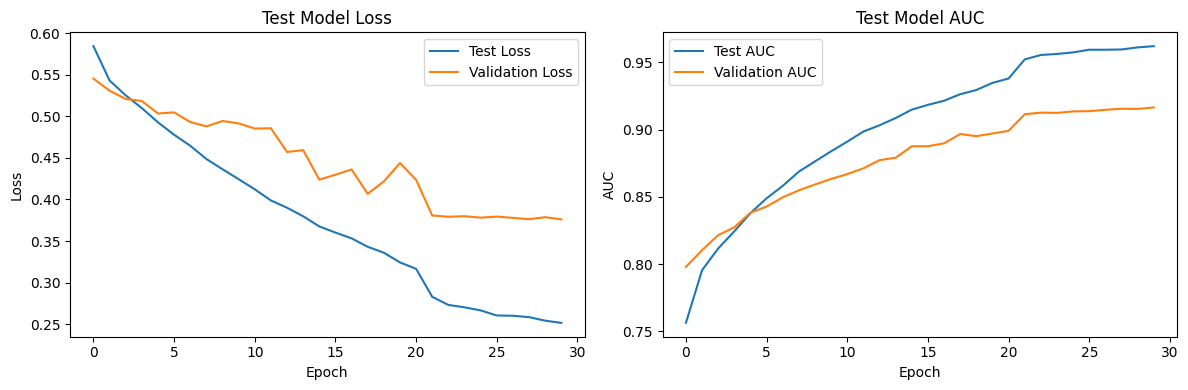

In [32]:
# Plot Loss and AUC for test set evaluation
plt.figure(figsize=(12, 4))

# Plot Loss for Test set
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Test Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC for Test set
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Test AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Test Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# **feature Importance**

# **permuting  feature importance**

In [33]:
def get_top_features(model, X, y, feature_names, n_features=10):
    baseline_score = accuracy_score(y, model.predict(X).round())
    feature_importances = np.zeros(X.shape[2])

    for feat_idx in tqdm(range(X.shape[2])):
        X_permuted = X.copy()
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])
        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score

    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]
    print("\nTop 10 Important Features:")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")
    return top_indices, feature_importances

In [35]:
# Cell 3: Execute feature importance calculation
from sklearn.metrics import accuracy_score
from tqdm import tqdm
print("Starting feature importance calculation...")
top_indices, feature_importances = get_top_features(
    model=model,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
    n_features=10
)

Starting feature importance calculation...
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 0/51 [00:00<?, ?it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 1/51 [00:00<00:32,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 2/51 [00:01<00:32,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  6%|▌         | 3/51 [00:01<00:31,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 4/51 [00:02<00:31,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|▉         | 5/51 [00:03<00:30,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 6/51 [00:03<00:29,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▎        | 7/51 [00:04<00:29,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 8/51 [00:05<00:28,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 9/51 [00:05<00:27,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|█▉        | 10/51 [00:06<00:27,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 11/51 [00:07<00:26,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▎       | 12/51 [00:07<00:26,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 13/51 [00:08<00:25,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 14/51 [00:09<00:24,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 15/51 [00:09<00:23,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███▏      | 16/51 [00:10<00:23,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 17/51 [00:11<00:22,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 18/51 [00:11<00:21,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 19/51 [00:12<00:21,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 20/51 [00:13<00:20,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 21/51 [00:13<00:19,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 22/51 [00:14<00:19,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 23/51 [00:15<00:18,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 24/51 [00:15<00:17,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 25/51 [00:16<00:17,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 26/51 [00:17<00:16,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 27/51 [00:17<00:15,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 28/51 [00:18<00:15,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 29/51 [00:19<00:14,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 30/51 [00:19<00:13,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 31/51 [00:20<00:13,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 32/51 [00:21<00:12,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 33/51 [00:21<00:11,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 34/51 [00:22<00:11,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▊   | 35/51 [00:23<00:10,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 36/51 [00:23<00:09,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 37/51 [00:24<00:09,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▍  | 38/51 [00:25<00:08,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▋  | 39/51 [00:25<00:07,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 40/51 [00:26<00:07,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 41/51 [00:27<00:06,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 42/51 [00:27<00:06,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 43/51 [00:28<00:05,  1.42it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▋ | 44/51 [00:29<00:04,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 45/51 [00:30<00:04,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 46/51 [00:30<00:03,  1.40it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 47/51 [00:31<00:02,  1.42it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 48/51 [00:32<00:02,  1.41it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 96%|█████████▌| 49/51 [00:32<00:01,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 50/51 [00:33<00:00,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Top 10 Important Features:
1. Temp: 0.0810
2. Resp: 0.0626
3. FiO2_observed: 0.0542
4. SBP: 0.0485
5. Platelets: 0.0431
6. MAP: 0.0430
7. Hgb: 0.0423
8. Magnesium: 0.0422
9. BUN: 0.0416
10. O2Sat: 0.0415


Starting feature importance calculation...
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  0%|          | 0/51 [00:00<?, ?it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 1/51 [00:00<00:33,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 2/51 [00:01<00:33,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  6%|▌         | 3/51 [00:02<00:34,  1.39it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 4/51 [00:02<00:32,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|▉         | 5/51 [00:03<00:31,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 6/51 [00:04<00:30,  1.48it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▎        | 7/51 [00:04<00:29,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 8/51 [00:05<00:28,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 9/51 [00:06<00:27,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|█▉        | 10/51 [00:06<00:27,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 11/51 [00:07<00:26,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▎       | 12/51 [00:08<00:25,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 13/51 [00:08<00:25,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 14/51 [00:09<00:24,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 15/51 [00:10<00:23,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███▏      | 16/51 [00:10<00:23,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 17/51 [00:11<00:22,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 18/51 [00:12<00:22,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 19/51 [00:12<00:21,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 20/51 [00:13<00:20,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 21/51 [00:14<00:19,  1.53it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 22/51 [00:14<00:18,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 23/51 [00:15<00:18,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 24/51 [00:15<00:17,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 25/51 [00:16<00:16,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 26/51 [00:17<00:16,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 27/51 [00:17<00:15,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▍    | 28/51 [00:18<00:14,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 29/51 [00:19<00:14,  1.54it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 30/51 [00:19<00:13,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 31/51 [00:20<00:13,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 32/51 [00:21<00:12,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 33/51 [00:21<00:11,  1.52it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 34/51 [00:22<00:11,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▊   | 35/51 [00:23<00:10,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 36/51 [00:23<00:09,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 37/51 [00:24<00:09,  1.48it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▍  | 38/51 [00:25<00:08,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▋  | 39/51 [00:25<00:08,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 40/51 [00:26<00:07,  1.48it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 41/51 [00:27<00:06,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 42/51 [00:27<00:06,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 43/51 [00:28<00:05,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▋ | 44/51 [00:29<00:04,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 45/51 [00:29<00:03,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 46/51 [00:30<00:03,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 47/51 [00:31<00:02,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 48/51 [00:31<00:02,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 96%|█████████▌| 49/51 [00:32<00:01,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 50/51 [00:33<00:00,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 51/51 [00:33<00:00,  1.50it/s]


Top 10 Important Features (Permutation Importance):
1. Temp: 0.0826
2. Resp: 0.0612
3. SBP: 0.0494
4. FiO2_observed: 0.0492
5. MAP: 0.0457
6. O2Sat: 0.0444
7. Magnesium: 0.0443
8. Platelets: 0.0440
9. DBP: 0.0423
10. Hgb: 0.0417


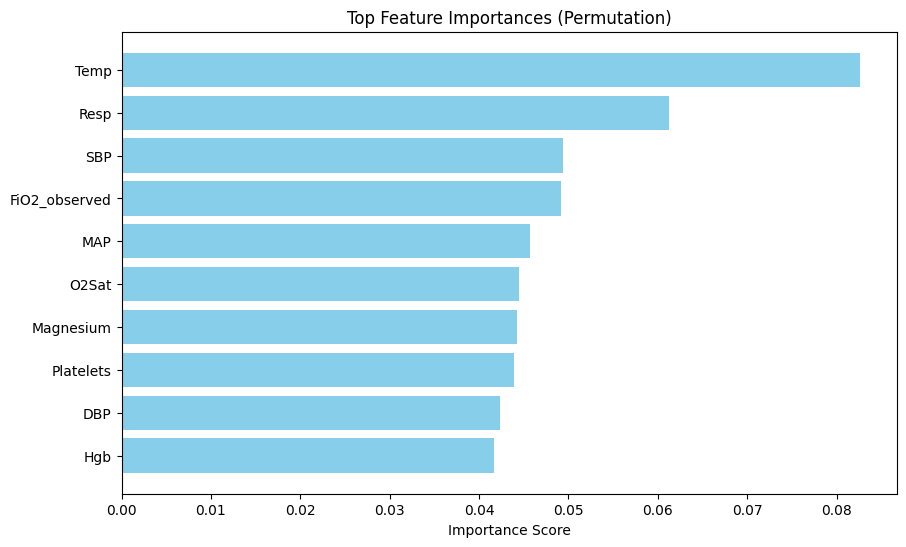

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_permutation_importance(model, X, y, feature_names, n_features=10):
    baseline_score = accuracy_score(y, model.predict(X).round())
    feature_importances = np.zeros(X.shape[2])

    for feat_idx in tqdm(range(X.shape[2])):
        X_permuted = X.copy()
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])
        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score

    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]
    
    print("\nTop 10 Important Features (Permutation Importance):")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")
    
    return top_indices, feature_importances

def plot_feature_importance(top_features):
    feature_names = [feat for feat, _ in top_features]
    importances = [imp for _, imp in top_features]
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel('Importance Score')
    plt.title('Top Feature Importances (Permutation)')
    plt.gca().invert_yaxis()
    plt.show()

print("Starting feature importance calculation...")
top_indices, feature_importances = get_permutation_importance(
    model=model,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
    n_features=10
)

plot_feature_importance(
    top_features=[(feature_cols[i], feature_importances[i]) for i in top_indices]
)


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import Model
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import pandas as pd

def apply_shap_to_sepsis_model(model, X_train, X_test, feature_cols):
    background_samples = min(100, len(X_train))
    background_indices = np.random.choice(len(X_train), background_samples, replace=False)
    X_background = X_train[background_indices]
    instance_to_explain = X_test[0:1]
    X_background_reshaped = X_background.reshape(background_samples, -1)
    instance_reshaped = instance_to_explain.reshape(1, -1)
    
    def model_predict(x):
        original_shape = (x.shape[0], X_train.shape[1], X_train.shape[2])
        x_reshaped = x.reshape(original_shape)
        return model.predict(x_reshaped, verbose=0)
    
    explainer = shap.KernelExplainer(model_predict, X_background_reshaped)
    shap_values = explainer.shap_values(instance_reshaped)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    shap_values_reshaped = shap_values.reshape(1, timesteps, n_features)
    
    return explainer, shap_values_reshaped
explainer, shap_values = apply_shap_to_sepsis_model(model, X_train, X_test, feature_cols)

  0%|          | 0/1 [00:00<?, ?it/s]

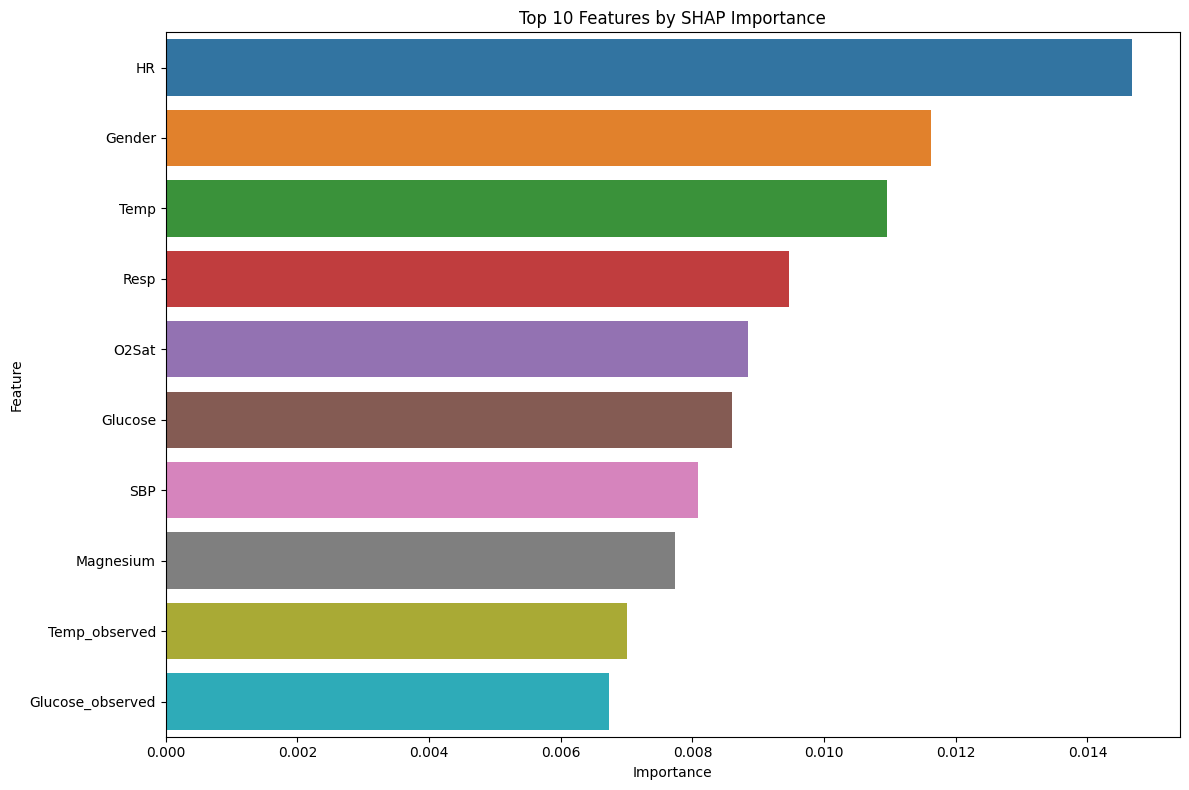

In [44]:
def plot_shap_bar(shap_values, feature_cols):
    feature_importance = np.abs(shap_values[0]).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Features by SHAP Importance')
    plt.tight_layout()
    plt.show()
plot_shap_bar(shap_values, feature_cols)

Starting feature importance calculation...
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:   0%|          | 0/51 [00:00<?, ?it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:   2%|▏         | 1/51 [00:00<00:33,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:   4%|▍         | 2/51 [00:01<00:33,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:   6%|▌         | 3/51 [00:02<00:32,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:   8%|▊         | 4/51 [00:02<00:31,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  10%|▉         | 5/51 [00:03<00:30,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  12%|█▏        | 6/51 [00:04<00:30,  1.48it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  14%|█▎        | 7/51 [00:04<00:29,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  16%|█▌        | 8/51 [00:05<00:28,  1.51it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  18%|█▊        | 9/51 [00:06<00:28,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  20%|█▉        | 10/51 [00:06<00:27,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  22%|██▏       | 11/51 [00:07<00:26,  1.50it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  24%|██▎       | 12/51 [00:08<00:26,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  25%|██▌       | 13/51 [00:08<00:25,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  27%|██▋       | 14/51 [00:09<00:24,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  29%|██▉       | 15/51 [00:10<00:24,  1.49it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  31%|███▏      | 16/51 [00:10<00:23,  1.48it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  33%|███▎      | 17/51 [00:11<00:23,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  35%|███▌      | 18/51 [00:12<00:22,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  37%|███▋      | 19/51 [00:12<00:21,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  39%|███▉      | 20/51 [00:13<00:21,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  41%|████      | 21/51 [00:14<00:20,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  43%|████▎     | 22/51 [00:14<00:19,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  45%|████▌     | 23/51 [00:15<00:19,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  47%|████▋     | 24/51 [00:16<00:18,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  49%|████▉     | 25/51 [00:16<00:17,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  51%|█████     | 26/51 [00:17<00:17,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  53%|█████▎    | 27/51 [00:18<00:16,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  55%|█████▍    | 28/51 [00:19<00:15,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  57%|█████▋    | 29/51 [00:19<00:15,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  59%|█████▉    | 30/51 [00:20<00:14,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Calculating importances:  61%|██████    | 31/51 [00:21<00:14,  1.42it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  63%|██████▎   | 32/51 [00:21<00:13,  1.41it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  65%|██████▍   | 33/51 [00:22<00:12,  1.42it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  67%|██████▋   | 34/51 [00:23<00:11,  1.43it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  69%|██████▊   | 35/51 [00:23<00:11,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  71%|███████   | 36/51 [00:24<00:10,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  73%|███████▎  | 37/51 [00:25<00:09,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  75%|███████▍  | 38/51 [00:25<00:08,  1.46it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  76%|███████▋  | 39/51 [00:26<00:08,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  78%|███████▊  | 40/51 [00:27<00:07,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  80%|████████  | 41/51 [00:28<00:06,  1.44it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  82%|████████▏ | 42/51 [00:28<00:06,  1.41it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  84%|████████▍ | 43/51 [00:29<00:05,  1.43it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  86%|████████▋ | 44/51 [00:30<00:04,  1.43it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  88%|████████▊ | 45/51 [00:30<00:04,  1.43it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  90%|█████████ | 46/51 [00:31<00:03,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  92%|█████████▏| 47/51 [00:32<00:02,  1.47it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  94%|█████████▍| 48/51 [00:32<00:02,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  96%|█████████▌| 49/51 [00:33<00:01,  1.45it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances:  98%|█████████▊| 50/51 [00:34<00:00,  1.43it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Calculating importances: 100%|██████████| 51/51 [00:35<00:00,  1.46it/s]


Top 10 Important Features (Permutation Importance):
1. Temp: 0.0744
2. Resp: 0.0581
3. FiO2_observed: 0.0510
4. SBP: 0.0507
5. Magnesium: 0.0493
6. O2Sat: 0.0458
7. Hct: 0.0414
8. MAP: 0.0405
9. Platelets: 0.0404
10. DBP: 0.0386


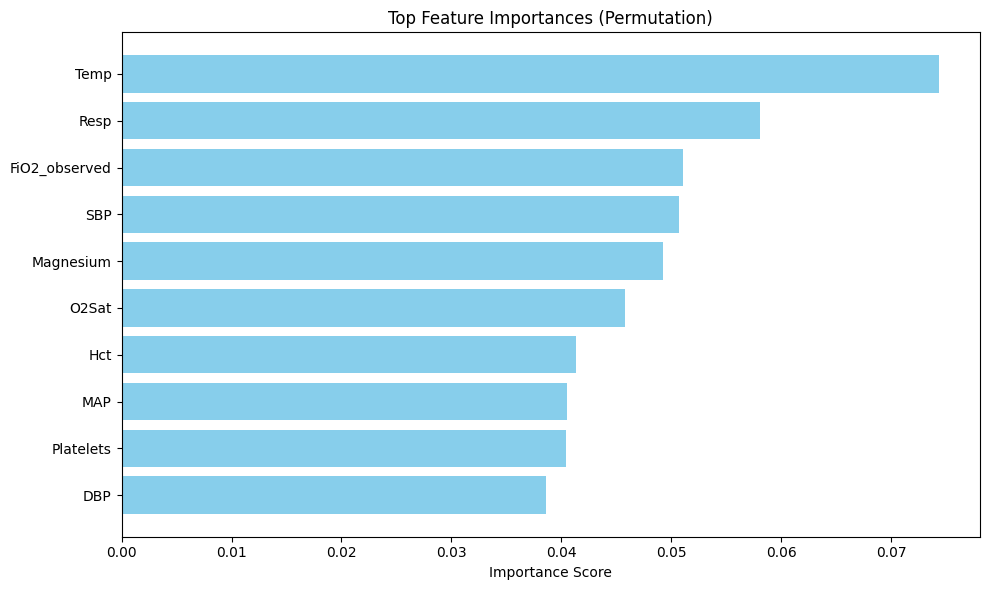

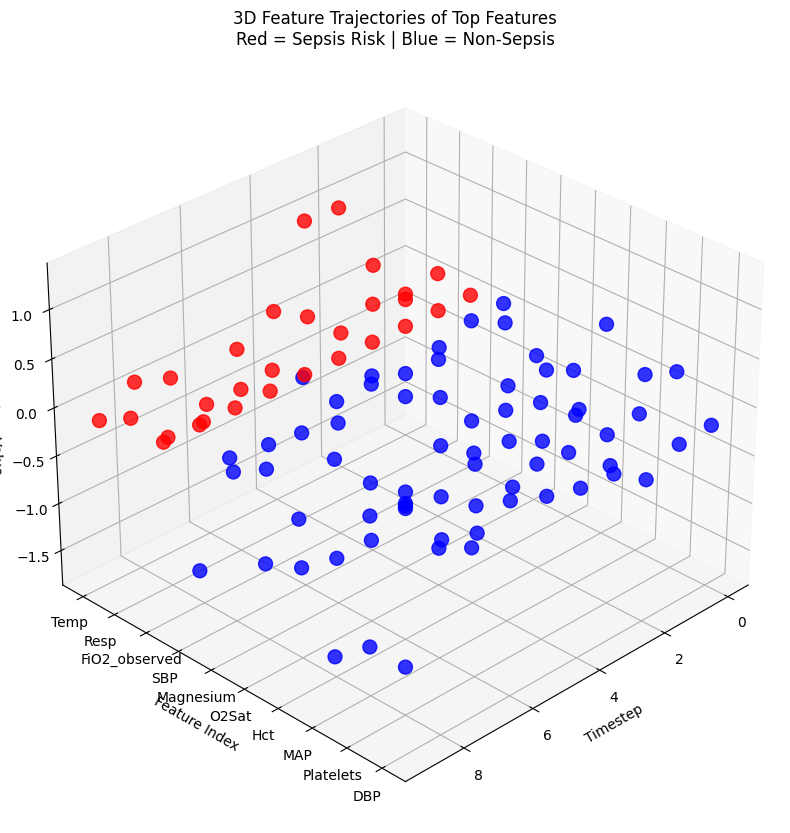

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tensorflow.keras.models import Model

def plot_3d_top_features(instance, top_indices, feature_names, timesteps, X_train, y_train):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate class-wise average feature values
    class_0_avg = np.mean(X_train[y_train == 0], axis=(0, 1))  # non-sepsis
    class_1_avg = np.mean(X_train[y_train == 1], axis=(0, 1))  # sepsis

    for i, feature_idx in enumerate(top_indices):
        feature_name = feature_names[feature_idx]
        x = np.arange(timesteps)
        y = np.full(timesteps, i)
        z = instance[:, feature_idx]

        # Determine color based on which class has a higher average value for this feature
        if class_1_avg[feature_idx] > class_0_avg[feature_idx]:
            color = 'red'  # Higher value = more likely sepsis
        else:
            color = 'blue'  # Higher value = more likely non-sepsis

        ax.scatter(
            x, y, z,
            color=color,
            s=100,
            alpha=0.8,
            label=feature_name
        )

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Feature Index')
    ax.set_zlabel('Feature Value')
    ax.set_yticks(range(len(top_indices)))
    ax.set_yticklabels([feature_names[i] for i in top_indices])
    ax.set_title('3D Feature Trajectories of Top Features\nRed = Sepsis Risk | Blue = Non-Sepsis')

    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()

def get_permutation_importance(model, X, y, feature_names, n_features=10):
    baseline_score = accuracy_score(y, model.predict(X).round())
    feature_importances = np.zeros(X.shape[2])

    for feat_idx in tqdm(range(X.shape[2]), desc="Calculating importances"):
        X_permuted = X.copy()
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])
        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score

    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]

    print("\nTop 10 Important Features (Permutation Importance):")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")

    return top_indices, feature_importances

def plot_feature_importance(top_features):
    feature_names = [feat for feat, _ in top_features]
    importances = [imp for _, imp in top_features]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel('Importance Score')
    plt.title('Top Feature Importances (Permutation)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ======== Example Usage ========
print("Starting feature importance calculation...")

top_indices, feature_importances = get_permutation_importance(
    model=model,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
    n_features=10
)

plot_feature_importance(
    top_features=[(feature_cols[i], feature_importances[i]) for i in top_indices]
)

# Plot 3D visualization of top features for one instance (e.g., first in test set)
plot_3d_top_features(
    instance=X_test[0],
    top_indices=top_indices,
    feature_names=feature_cols,
    timesteps=X_test.shape[1],
    X_train=X_train,
    y_train=y_train
)


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Calculating permutation importance over time...


Features:   0%|          | 0/51 [00:00<?, ?it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:   2%|▏         | 1/51 [00:06<05:38,  6.77s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Features:   4%|▍         | 2/51 [00:13<05:35,  6.84s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:   6%|▌         | 3/51 [00:20<05:26,  6.81s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:   8%|▊         | 4/51 [00:27<05:21,  6.84s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  10%|▉         | 5/51 [00:34<05:13,  6.81s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  12%|█▏        | 6/51 [00:41<05:10,  6.90s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  14%|█▎        | 7/51 [00:48<05:07,  6.98s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  16%|█▌        | 8/51 [00:55<04:59,  6.97s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  18%|█▊        | 9/51 [01:02<04:53,  6.98s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  20%|█▉        | 10/51 [01:09<04:45,  6.96s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  22%|██▏       | 11/51 [01:15<04:36,  6.92s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  24%|██▎       | 12/51 [01:23<04:33,  7.01s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  25%|██▌       | 13/51 [01:30<04:24,  6.96s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  27%|██▋       | 14/51 [01:37<04:17,  6.96s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  29%|██▉       | 15/51 [01:43<04:10,  6.95s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  31%|███▏      | 16/51 [01:50<04:02,  6.94s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  33%|███▎      | 17/51 [01:57<03:51,  6.81s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  35%|███▌      | 18/51 [02:03<03:41,  6.71s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  37%|███▋      | 19/51 [02:10<03:33,  6.68s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  39%|███▉      | 20/51 [02:17<03:26,  6.65s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  41%|████      | 21/51 [02:23<03:19,  6.66s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  43%|████▎     | 22/51 [02:30<03:12,  6.62s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  45%|████▌     | 23/51 [02:36<03:05,  6.61s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  47%|████▋     | 24/51 [02:43<02:58,  6.60s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  49%|████▉     | 25/51 [02:49<02:51,  6.60s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  51%|█████     | 26/51 [02:56<02:45,  6.63s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  53%|█████▎    | 27/51 [03:03<02:38,  6.61s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  55%|█████▍    | 28/51 [03:09<02:31,  6.60s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  57%|█████▋    | 29/51 [03:16<02:24,  6.57s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  59%|█████▉    | 30/51 [03:22<02:16,  6.52s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  61%|██████    | 31/51 [03:29<02:11,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  63%|██████▎   | 32/51 [03:35<02:04,  6.54s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  65%|██████▍   | 33/51 [03:42<01:57,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  67%|██████▋   | 34/51 [03:49<01:51,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Features:  69%|██████▊   | 35/51 [03:55<01:45,  6.57s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  71%|███████   | 36/51 [04:02<01:38,  6.57s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  73%|███████▎  | 37/51 [04:08<01:31,  6.57s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  75%|███████▍  | 38/51 [04:15<01:25,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  76%|███████▋  | 39/51 [04:21<01:18,  6.56s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  78%|███████▊  | 40/51 [04:28<01:12,  6.61s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  80%|████████  | 41/51 [04:35<01:05,  6.57s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  82%|████████▏ | 42/51 [04:41<00:58,  6.52s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  84%|████████▍ | 43/51 [04:47<00:52,  6.52s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  86%|████████▋ | 44/51 [04:54<00:45,  6.52s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  88%|████████▊ | 45/51 [05:01<00:39,  6.58s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  90%|█████████ | 46/51 [05:07<00:32,  6.56s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  92%|█████████▏| 47/51 [05:14<00:26,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  94%|█████████▍| 48/51 [05:20<00:19,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  96%|█████████▌| 49/51 [05:27<00:13,  6.54s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features:  98%|█████████▊| 50/51 [05:33<00:06,  6.55s/it]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Features: 100%|██████████| 51/51 [05:40<00:00,  6.68s/it]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

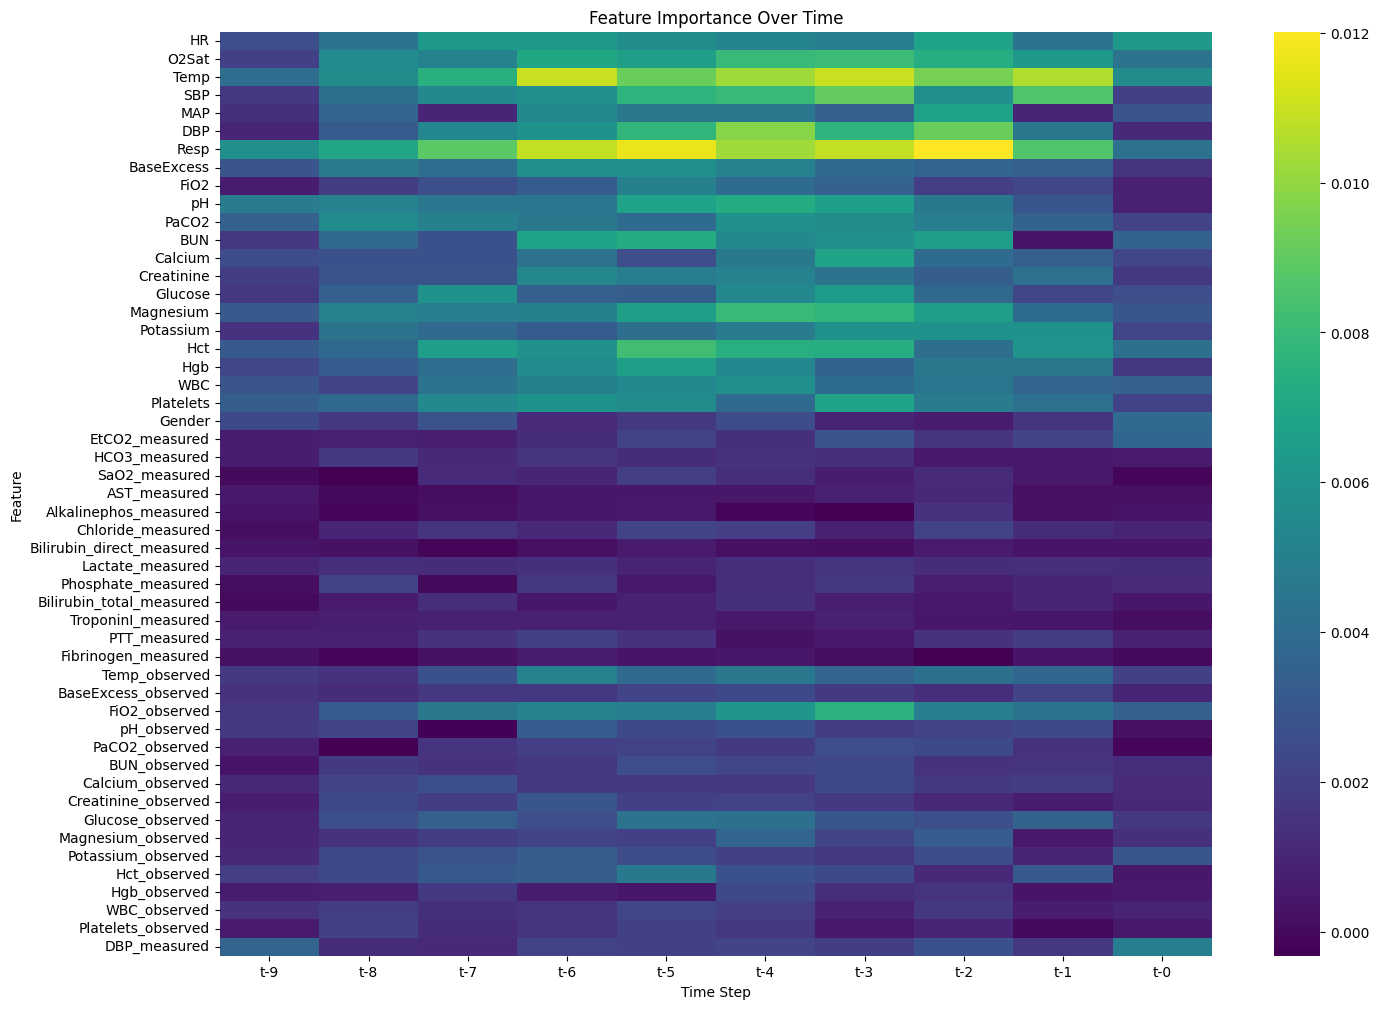

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def get_time_resolved_permutation_importance(model, X, y, feature_names):
    n_samples, n_timesteps, n_features = X.shape
    baseline_score = accuracy_score(y, model.predict(X).round())
    importances = np.zeros((n_features, n_timesteps))

    print("Calculating permutation importance over time...")
    for feat_idx in tqdm(range(n_features), desc="Features"):
        for t in range(n_timesteps):
            X_permuted = X.copy()
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])
            permuted_score = accuracy_score(y, model.predict(X_permuted).round())
            importances[feat_idx, t] = baseline_score - permuted_score

    return importances

def plot_time_resolved_heatmap(importances, feature_names, time_steps):
    plt.figure(figsize=(16, 12))
    sns.heatmap(importances, cmap='viridis', xticklabels=time_steps, yticklabels=feature_names)
    plt.xlabel("Time Step")
    plt.ylabel("Feature")
    plt.title("Feature Importance Over Time")
    plt.colorbar(label='Permutation Importance')
    plt.tight_layout()
    plt.show()

# ======= Example Usage =======
# Assume: model, X_test, y_test, feature_cols already defined
importances = get_time_resolved_permutation_importance(model, X_test, y_test, feature_cols)
plot_time_resolved_heatmap(importances, feature_cols, [f"t-{i}" for i in reversed(range(X_test.shape[1]))])


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Model
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import log_loss

def permutation_importance_conv1d(model, X, y, metric=log_loss):
    baseline_preds = model.predict(X, verbose=0)
    baseline_score = metric(y, baseline_preds)

    importance_matrix = np.zeros(X.shape[1:])  # shape: (timesteps, features)

    for t in range(X.shape[1]):
        for f in range(X.shape[2]):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, t, f])
            preds = model.predict(X_permuted, verbose=0)
            score = metric(y, preds)
            importance_matrix[t, f] = score - baseline_score

    return importance_matrix

def plot_feature_3d_conv1d_permutation(model, X_background, X_sample, y_background, feature_names):
    if len(X_sample.shape) == 3:
        X_sample = X_sample[0]

    # Compute permutation importance
    print("Computing permutation importances (this may take some time)...")
    importances = permutation_importance_conv1d(model, X_background, y_background)

    mean_importances = np.mean(importances, axis=0)
    top_indices = np.argsort(mean_importances)[::-1][:10]
    max_timesteps = X_sample.shape[0]

    # Widget setup
    feature_dropdown = widgets.Dropdown(
        options=[(feature_names[i], i) for i in top_indices],
        value=top_indices[0],
        description='Feature:'
    )

    timestep_start = widgets.IntSlider(
        value=0,
        min=0,
        max=max_timesteps - 1,
        step=1,
        description='Start Time:',
        continuous_update=False
    )

    timestep_end = widgets.IntSlider(
        value=min(10, max_timesteps),
        min=1,
        max=max_timesteps,
        step=1,
        description='End Time:',
        continuous_update=False
    )

    out = widgets.Output()

    def update_end_min(change):
        timestep_end.min = change.new + 1
        if timestep_end.value <= change.new:
            timestep_end.value = change.new + 1

    timestep_start.observe(update_end_min, names='value')

    # Get relevant layer outputs
    layer_models = []
    for layer in model.layers:
        if layer.__class__.__name__ in ['Conv1D', 'GlobalAveragePooling1D', 'Dense']:
            try:
                layer_models.append((layer.name, Model(inputs=model.input, outputs=layer.output)))
            except:
                pass

    def plot_3d(feature_idx, start_time, end_time):
        with out:
            out.clear_output(wait=True)

            selected_timesteps = list(range(start_time, end_time))
            fig = plt.figure(figsize=(16, 12))
            ax = fig.add_subplot(111, projection='3d')

            feature_importance_subset = importances[selected_timesteps, feature_idx]
            norm = plt.Normalize(vmin=np.min(feature_importance_subset), vmax=np.max(feature_importance_subset))
            cmap = plt.get_cmap('coolwarm')

            for layer_idx, (layer_name, layer_model) in enumerate(layer_models):
                try:
                    layer_output = layer_model.predict(np.expand_dims(X_sample, 0), verbose=0)
                    if len(layer_output.shape) == 3:
                        activations = layer_output[0][selected_timesteps]
                    elif len(layer_output.shape) == 2:
                        activations = np.tile(layer_output, (len(selected_timesteps), 1))
                    else:
                        continue

                    for unit in range(min(5, activations.shape[1])):
                        y_vals = activations[:, unit]

                        sc = ax.scatter(
                            selected_timesteps,
                            np.full(len(selected_timesteps), layer_idx),
                            y_vals,
                            c=feature_importance_subset,
                            cmap=cmap,
                            norm=norm,
                            alpha=0.8,
                            s=100,
                            edgecolor='w',
                            linewidth=0.5,
                            label=f'{layer_name} (unit {unit})' if unit == 0 else ""
                        )

                        ax.plot(
                            selected_timesteps,
                            np.full(len(selected_timesteps), layer_idx),
                            y_vals,
                            color='gray',
                            alpha=0.3,
                            linewidth=0.5
                        )

                except Exception as e:
                    print(f"Error processing layer {layer_name}: {str(e)}")
                    continue

            ax.set_yticks(range(len(layer_models)))
            ax.set_yticklabels([name for name, _ in layer_models], fontsize=10)
            ax.set_xticks(selected_timesteps)
            ax.set_xticklabels([str(t) for t in selected_timesteps], fontsize=8, rotation=45)

            ax.set_title(f'Feature: {feature_names[feature_idx]} | Timesteps: {start_time}-{end_time-1}', fontsize=14, pad=20)
            ax.set_xlabel('\nTimesteps', fontsize=12, linespacing=3.0)
            ax.set_ylabel('\nModel Layers', fontsize=12, linespacing=3.0)
            ax.set_zlabel('\nActivation Value', fontsize=12, linespacing=3.0)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, pad=0.1)
            cbar.set_label('Permutation Importance', rotation=270, labelpad=20)

            ax.view_init(elev=25, azim=-45)
            ax.grid(True, alpha=0.3)

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

            handles, labels = ax.get_legend_handles_labels()
            if handles:
                ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.15, 0.8), fontsize=10)

            plt.tight_layout()
            plt.show()

    def update_plot(change):
        plot_3d(feature_dropdown.value, timestep_start.value, timestep_end.value)

    feature_dropdown.observe(update_plot, names='value')
    timestep_start.observe(update_plot, names='value')
    timestep_end.observe(update_plot, names='value')

    plot_3d(top_indices[0], timestep_start.value, timestep_end.value)

    display(widgets.VBox([
        widgets.HBox([feature_dropdown]),
        widgets.HBox([timestep_start, timestep_end]),
        out
    ]))
plot_feature_3d_conv1d_permutation(model, X_train[:100], X_test[0], y_train[:100], feature_names=feature_cols)


Computing permutation importances (this may take some time)...


In [ ]:
def create_feature_importance_plot(model, X_background, X_sample, feature_names):
    """
    Create static bar plot of feature importance using SHAP values
    
    Args:
        model: Trained Keras model
        X_background: Background data for SHAP
        X_sample: Sample to explain
        feature_names: List of feature names
        
    Returns:
        DataFrame with feature importance
    """
    # Initialize SHAP explainer
    def model_predict(X):
        return model.predict(X.reshape(-1, X_background.shape[1], X_background.shape[2]))
    
    background_subset = X_background[np.random.choice(
        len(X_background), 
        min(100, len(X_background)), 
        replace=False
    )].reshape(-1, X_background.shape[1] * X_background.shape[2])
    
    explainer = shap.KernelExplainer(model_predict, background_subset)
    
    # Calculate SHAP values
    X_flat = X_sample.reshape(X_sample.shape[0], -1)
    shap_values = explainer.shap_values(X_flat)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    reshaped_values = shap_values.reshape(X_sample.shape)
    mean_abs_shap = np.mean(np.abs(reshaped_values), axis=(0,1))
    
    # Create dataframe for plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_abs_shap
    }).sort_values('Importance', ascending=False).head(10)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Sepsis Prediction')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Example usage:
importance_df = create_feature_importance_plot(model, X_train[:100], X_test[:10], feature_cols)

In [ ]:
def create_shap_heatmap_by_class(model, X_background, X_samples, y_samples, feature_names):
    """
    Create heatmaps separating sepsis vs non-sepsis patients
    
    Args:
        model: Trained Keras model
        X_background: Background data for SHAP
        X_samples: Sample data
        y_samples: Labels
        feature_names: List of feature names
        
    Returns:
        Tuple of (top_indices, top_features)
    """
    # Initialize SHAP explainer
    def model_predict(X):
        return model.predict(X.reshape(-1, X_background.shape[1], X_background.shape[2]))
    
    background_subset = X_background[np.random.choice(
        len(X_background), 
        min(100, len(X_background)), 
        replace=False
    )].reshape(-1, X_background.shape[1] * X_background.shape[2])
    
    explainer = shap.KernelExplainer(model_predict, background_subset)
    
    # Separate sepsis from non-sepsis
    sepsis_indices = np.where(y_samples == 1)[0][:5]
    non_sepsis_indices = np.where(y_samples == 0)[0][:5]
    
    X_sepsis = X_samples[sepsis_indices]
    X_non_sepsis = X_samples[non_sepsis_indices]
    
    # Calculate SHAP values
    def get_shap(X):
        X_flat = X.reshape(X.shape[0], -1)
        sv = explainer.shap_values(X_flat)
        return sv[0] if isinstance(sv, list) else sv
    
    shap_sepsis = np.mean([get_shap(np.expand_dims(x, 0)) for x in X_sepsis], axis=0)
    shap_non_sepsis = np.mean([get_shap(np.expand_dims(x, 0)) for x in X_non_sepsis], axis=0)
    
    # Reshape and find top features
    shap_sepsis = shap_sepsis.reshape(X_sepsis[0].shape)
    shap_non_sepsis = shap_non_sepsis.reshape(X_non_sepsis[0].shape)
    
    mean_abs_diff = np.mean(np.abs(shap_sepsis - shap_non_sepsis), axis=0)
    top_indices = np.argsort(mean_abs_diff)[::-1][:10]
    top_features = [feature_names[i] for i in top_indices]
    
    # Create heatmaps
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Sepsis heatmap
    sns.heatmap(
        shap_sepsis[:, top_indices].T,
        cmap='coolwarm',
        center=0,
        annot=False,
        yticklabels=top_features,
        xticklabels=[f'T{i}' for i in range(X_background.shape[1])],
        ax=axes[0]
    )
    axes[0].set_title('SHAP Values Across Timesteps - Sepsis Patients')
    
    # Non-sepsis heatmap
    sns.heatmap(
        shap_non_sepsis[:, top_indices].T,
        cmap='coolwarm',
        center=0,
        annot=False,
        yticklabels=top_features,
        xticklabels=[f'T{i}' for i in range(X_background.shape[1])],
        ax=axes[1]
    )
    axes[1].set_title('SHAP Values Across Timesteps - Non-sepsis Patients')
    
    plt.tight_layout()
    plt.show()
    
    return top_indices, top_features

# Example usage:
top_indices, top_features = create_shap_heatmap_by_class(model, X_train[:100], X_test, y_test, feature_cols)

In [ ]:
!pip install ipywidgets


In [ ]:
!pip install numpy matplotlib tensorflow shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def plot_feature_3d_conv1d_enhanced(model, X_background, X_sample, feature_names):
    # Data preparation
    if len(X_sample.shape) == 3:
        X_sample = X_sample[0]
    
    # Get layer outputs
    layer_outputs = {}
    for layer in model.layers:
        if 'conv1d' in layer.name.lower() or 'dense' in layer.name.lower():
            try:
                layer_model = Model(inputs=model.input, outputs=layer.output)
                layer_outputs[layer.name] = layer_model.predict(np.expand_dims(X_sample, 0))[0]
            except:
                continue
    
    # Widget setup
    feature_dropdown = widgets.Dropdown(
        options=[(name, idx) for idx, name in enumerate(feature_names)],
        description='Feature:'
    )
    
    time_slider = widgets.IntRangeSlider(
        value=[0, min(9, X_sample.shape[0]-1)],
        min=0,
        max=X_sample.shape[0]-1,
        step=1,
        description='Time Steps:',
        continuous_update=False
    )
    
    out = widgets.Output()
    
    def update_plot(feature_idx, time_range):
        with out:
            out.clear_output(wait=True)
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Get selected time steps
            timesteps = np.arange(time_range[0], time_range[1]+1)
            feature_values = X_sample[timesteps, feature_idx]
            
            # Color normalization
            norm = plt.Normalize(vmin=np.min(feature_values), vmax=np.max(feature_values))
            cmap = plt.get_cmap('viridis')
            
            # Plot each layer's activations
            for layer_idx, (layer_name, outputs) in enumerate(layer_outputs.items()):
                # Handle different output shapes
                if len(outputs.shape) == 1:
                    activations = np.tile(outputs, (len(timesteps), 1))
                else:
                    activations = outputs[timesteps]
                
                # Plot first 3 units for clarity
                for unit in range(min(3, activations.shape[1])):
                    ax.scatter(
                        timesteps,
                        np.full(len(timesteps), layer_idx),
                        activations[:, unit],
                        c=feature_values,
                        cmap=cmap,
                        norm=norm,
                        s=80,
                        alpha=0.8,
                        label=f'{layer_name} (unit {unit})' if unit == 0 else None
                    )
            
            # Customize axes
            ax.set_yticks(range(len(layer_outputs)))
            ax.set_yticklabels(list(layer_outputs.keys()))
            ax.set_xlabel('\nTime Steps', fontsize=12)
            ax.set_ylabel('\nLayers', fontsize=12)
            ax.set_zlabel('\nActivation Values', fontsize=12)
            ax.set_title(f'Feature: {feature_names[feature_idx]} ({time_range[0]}-{time_range[1]})', fontsize=14)
            
            # Add colorbar
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            plt.colorbar(sm, ax=ax, label='Feature Value')
            
            # Set viewing angle
            ax.view_init(elev=30, azim=45)
            
            plt.tight_layout()
            plt.show()
    
    # Connect widgets to update function
    widgets.interactive(update_plot, 
                       feature_idx=feature_dropdown, 
                       time_range=time_slider)
    
    # Display the widgets
    display(widgets.VBox([feature_dropdown, time_slider, out]))

In [ ]:
plot_feature_3d_conv1d(model, X_train[:1], X_test[0], feature_names=feature_cols)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Model
import shap
import ipywidgets as widgets
from IPython.display import display

def plot_feature_3d_conv1d(model, X_background, X_sample, feature_names):
    if len(X_sample.shape) == 3:
        X_sample = X_sample[0]
        
    def model_predict(X):
        return model.predict(X.reshape(-1, X_background.shape[1], X_background.shape[2]), verbose=0)
    
    background_subset = X_background[np.random.choice(
        len(X_background), 
        min(100, len(X_background)), 
        replace=False
    )].reshape(-1, X_background.shape[1] * X_background.shape[2])
    
    explainer = shap.KernelExplainer(model_predict, background_subset)
    
    # Get all relevant layers
    layer_models = []
    for layer in model.layers:
        if layer.__class__.__name__ in ['Conv1D', 'GlobalAveragePooling1D', 'Dense']:
            try:
                layer_models.append((layer.name, Model(inputs=model.input, outputs=layer.output)))
            except:
                pass
    
    # Calculate SHAP values
    X_flat = np.expand_dims(X_sample, 0).reshape(1, -1)
    shap_values = explainer.shap_values(X_flat)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    shap_values = shap_values.reshape(np.expand_dims(X_sample, 0).shape)[0]
    
    # Select top features
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]
    
    # Max available timesteps
    max_timesteps = X_sample.shape[0]
    
    # Widget setup
    feature_dropdown = widgets.Dropdown(
        options=[(feature_names[i], i) for i in top_indices],
        value=top_indices[0],
        description='Feature:'
    )
    
    # Time step range slider
    timestep_start = widgets.IntSlider(
        value=0,
        min=0,
        max=max_timesteps-1,
        step=1,
        description='Start Time:',
        continuous_update=False
    )
    
    timestep_end = widgets.IntSlider(
        value=min(10, max_timesteps),  # Default to 10 timesteps or max available
        min=1,
        max=max_timesteps,
        step=1,
        description='End Time:',
        continuous_update=False
    )
    
    # Output widget for plot
    out = widgets.Output()
    
    def update_end_min(change):
        """Update the minimum value of end slider when start slider changes"""
        timestep_end.min = change.new + 1
        if timestep_end.value <= change.new:
            timestep_end.value = change.new + 1
    
    timestep_start.observe(update_end_min, names='value')
    
    def plot_3d(feature_idx, start_time, end_time):
        with out:
            out.clear_output(wait=True)
            
            # Ensure valid time range
            start_time = max(0, start_time)
            end_time = min(max_timesteps, end_time)
            if start_time >= end_time:
                end_time = start_time + 1
            
            # Create time steps with exactly 1 step increment
            selected_timesteps = list(range(start_time, end_time))
            
            fig = plt.figure(figsize=(16, 12))
            ax = fig.add_subplot(111, projection='3d')
            
            feature_shap = shap_values[:, feature_idx]
            feature_shap_subset = feature_shap[selected_timesteps]
            
            # Color normalization based on SHAP values
            norm = plt.Normalize(vmin=np.min(feature_shap_subset), 
                               vmax=np.max(feature_shap_subset))
            cmap = plt.get_cmap('coolwarm')
            
            # Plot each layer's activations
            for layer_idx, (layer_name, layer_model) in enumerate(layer_models):
                try:
                    layer_output = layer_model.predict(np.expand_dims(X_sample, 0), verbose=0)
                    
                    if len(layer_output.shape) == 3:  # Conv1D output
                        # Get activations for selected time steps
                        activations = layer_output[0][selected_timesteps]
                    elif len(layer_output.shape) == 2:  # Dense or GlobalPooling
                        if layer_output.shape[0] == 1:
                            # Repeat for all timesteps
                            activations = np.tile(layer_output, (len(selected_timesteps), 1))
                        else:
                            activations = layer_output[selected_timesteps]
                    else:
                        continue
                    
                    # Plot only first 5 units for clarity
                    for unit in range(min(5, activations.shape[1])):
                        y_vals = activations[:, unit]
                        
                        # Create scatter plot with color mapping
                        sc = ax.scatter(
                            selected_timesteps,  # Use actual time step values
                            np.full(len(selected_timesteps), layer_idx),
                            y_vals,
                            c=feature_shap_subset,
                            cmap=cmap,
                            norm=norm,
                            alpha=0.8,
                            s=100,
                            edgecolor='w',
                            linewidth=0.5,
                            label=f'{layer_name} (unit {unit})' if unit == 0 else ""
                        )
                        
                        # Add connecting lines for better visibility
                        ax.plot(selected_timesteps,
                               np.full(len(selected_timesteps), layer_idx),
                               y_vals,
                               color='gray',
                               alpha=0.3,
                               linewidth=0.5)
                        
                except Exception as e:
                    print(f"Error processing layer {layer_name}: {str(e)}")
                    continue
            
            # Customize axes and labels
            ax.set_yticks(range(len(layer_models)))
            ax.set_yticklabels([name for name, _ in layer_models], fontsize=10)
            
            # Set x-axis ticks to show each time step individually
            ax.set_xticks(selected_timesteps)
            ax.set_xticklabels([str(t) for t in selected_timesteps], fontsize=8, rotation=45)
            
            ax.set_title(f'Feature: {feature_names[feature_idx]} | Timesteps: {start_time}-{end_time-1}', 
                        fontsize=14, pad=20)
            ax.set_xlabel('\nTimesteps', fontsize=12, linespacing=3.0)
            ax.set_ylabel('\nModel Layers', fontsize=12, linespacing=3.0)
            ax.set_zlabel('\nActivation Value', fontsize=12, linespacing=3.0)
            
            # Add colorbar
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, pad=0.1)
            cbar.set_label('SHAP Value', rotation=270, labelpad=20)
            
            # Set viewing angle for optimal visibility
            ax.view_init(elev=25, azim=-45)
            
            # Add grid and adjust layout
            ax.grid(True, alpha=0.3)
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            
            # Add legend
            handles, labels = ax.get_legend_handles_labels()
            if handles:
                ax.legend(handles=handles, labels=labels, 
                         bbox_to_anchor=(1.15, 0.8), 
                         fontsize=10)
            
            plt.tight_layout()
            plt.show()
    
    def update_plot(change):
        plot_3d(feature_dropdown.value, timestep_start.value, timestep_end.value)
    
    # Observe all widget changes
    feature_dropdown.observe(update_plot, names='value')
    timestep_start.observe(update_plot, names='value')
    timestep_end.observe(update_plot, names='value')
    
    # Initial plot
    plot_3d(top_indices[0], timestep_start.value, timestep_end.value)
    
    # Display widgets in an organized layout
    display(widgets.VBox([
        widgets.HBox([feature_dropdown]),
        widgets.HBox([timestep_start, timestep_end]),
        out
    ]))
plot_feature_3d_conv1d(model, X_train[:100], X_test[0], feature_names=feature_cols)